# Introduction

## Definiton

* An autoencoder (AE) is an artificial neural network that **reconstructs** the input by first embedding it in to **latent space** first, and then rebuilds it by de-mapping operation.
* Well, from this definition, AEs seems a bit redundant. But lets dive into the autoencoders.
    * First of all this is the definition of the simplest/traditional AE.
    * We can train an AE to reconstruct the output from *noisy* samples (denoising AE).
    * Or we can train an AE to learn the distribution to have a generative model, called variational AE.
    * There are some well-established applications of AEs, such as outlier detection.
    * We also reduce the input size significantly. This is also useful in many cases.
* In this definition, two keywords are bolded. To understand these keywords, lets think about traditional AE.
    * Reconstruction: The goal of AE is reconstructing the desired output while minimizing the loss. Two specialized components are responsible for this task: *encoder* and *decoder*. As their name suggest, the encoder focuses on mapping the input into latent space, and the decoder takes this latent space representation to recrate the desired input. The loss function is usually *MAE* or *MSE*.
    * Latent space: The dimension of the latent space is dramatically smaller. The smaller the dimension, the harder it is to reconstruct, but the higher dimensions are making AE meaningless. This trade-off should be taken care of in hyperparameter tuning and is highly application dependent.
* Here is a simple illustration of the AE.

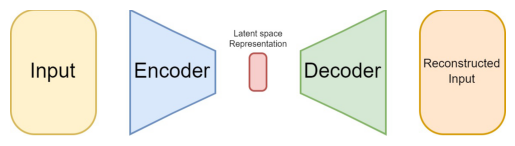

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("AE_Figure1.jpg")
plt.imshow(img)
plt.axis('off')
plt.show()

## Mathematical basis

The mathematics behind traditional AE is simple and easy to understand.
* During training, the AE learns two different functions
    * The embedding function $\rightarrow$ $h = f (x)$
    * The de-embedding function $\rightarrow$ $x' = g (h)$
    * where $x$ is the input, $h$ is the latent space representation and $x'$ is the reconstructed input.
    * Please notice that $dim(h) \ll dim(x) $ 
* The learnable weights are updated in backpropagation by minimizing the loss $L$. Any suitable loss function will work, here is the example using squared error.
    * $L (x, x') = || x - x' ||^2$
    
Note: *For the sake of simplicity the concepts of non-linear activation functions, matrix notations, derivations and regularizations are not mentioned here, as they are basics for machine learning.*

## Implementation

### Traditional autoencoder implementation

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f

First, we will build an autoencoder without using dense layers in the nn.Module library. In this approach, I have adopted two layered encoder and decoder, and implemented them separately for ease of understanding.

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.input_dim = input_dim
        
        self.weight_L1 = nn.Parameter(torch.FloatTensor(self.input_dim, self.emb_dim * 2))
        self.weight_L2 = nn.Parameter(torch.FloatTensor(self.emb_dim * 2, self.emb_dim))
        
        self.initialize_parameters()
        
    def initialize_parameters(self):
        nn.init.xavier_uniform_(self.weight_L1)
        nn.init.xavier_uniform_(self.weight_L2)
    
    def forward(self, x):
        h = torch.matmul(x, self.weight_L1)
        h = f.leaky_relu(h)
        
        h = torch.matmul(h, self.weight_L2)
        h = f.leaky_relu(h)
        
        return h


class Decoder(nn.Module):
    def __init__(self, emb_dim, input_dim):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.input_dim = input_dim
        
        self.weight_L1 = nn.Parameter(torch.FloatTensor(self.emb_dim, self.emb_dim * 2))
        self.weight_L2 = nn.Parameter(torch.FloatTensor(self.emb_dim * 2, self.input_dim))
        
        self.initialize_parameters()
        
    def initialize_parameters(self):
        nn.init.xavier_uniform_(self.weight_L1)
        nn.init.xavier_uniform_(self.weight_L2)
    
    def forward(self, x):
        h = torch.matmul(x, self.weight_L1)
        h = f.leaky_relu(h)        
        h = torch.matmul(h, self.weight_L2)
        
        return h 
        
class Autoencoder(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.input_dim = input_dim
        
        self.encoder = Encoder(self.input_dim, self.emb_dim)
        self.decoder = Decoder(self.emb_dim, self.input_dim)
        
    def forward(self, x):
        return self.decoder(self.encoder(x))
    

I used leaky relu as the non-linear activation function. The dimensions are as $n \rightarrow 2h \rightarrow h \rightarrow 2h \rightarrow n$, where n is the input and h is the embedding dimension.

Now, it is time to test! Using image datasets is easier to understand/see the difference. We simply use the datasets provided by pytorch, links are [torch datasets](https://pytorch.org/vision/main/datasets.html) and [torch data tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)

I only implemented the train part, as our focus is on understanding how the autoencoder works. Testing is left to readers :)

Now, lets define model, loss and optimizer.

In [6]:
model = Autoencoder(784, 16) # 784 = 28 * 28
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

In [7]:
epoch = 10
for e in range(epoch):
    train_loss = 0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    if (e + 1) % 2 == 0 or e == 0:
        print(f"Epoch: {e+1}\tTrain loss: {train_loss:.4f}")

Epoch: 1	Train loss: 32.7440
Epoch: 2	Train loss: 21.7049
Epoch: 4	Train loss: 19.8750
Epoch: 6	Train loss: 19.2421
Epoch: 8	Train loss: 18.7862
Epoch: 10	Train loss: 18.3984


The training is finished, let us check some pictures.

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

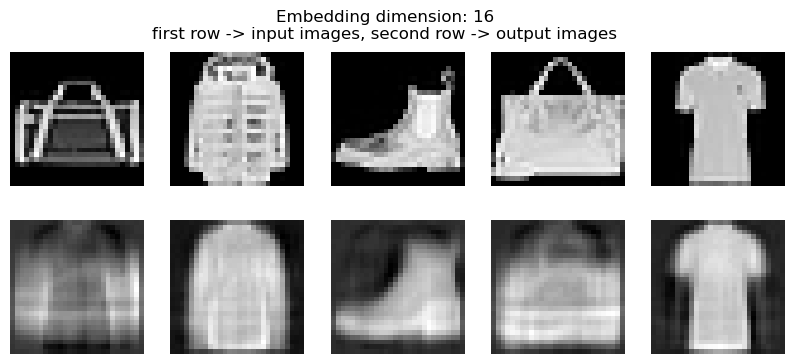

In [9]:
ex = 5

inputs = inputs[:ex]
outputs = outputs[:ex]

inputs = inputs.detach().numpy()
outputs_16 = outputs.detach().numpy()

plt.figure(figsize=(10, 4))

for i in range(ex):
    plt.subplot(2, ex, i + 1)
    plt.imshow(np.reshape(inputs[i], (28, 28)), cmap='gray')
    plt.axis('off')

    plt.subplot(2, ex, i + ex + 1)
    plt.imshow(np.reshape(outputs_16[i], (28, 28)), cmap='gray')
    plt.axis('off')

plt.suptitle("Embedding dimension: 16\nfirst row -> input images, second row -> output images")

plt.show()

Results are decent. But lets increase the embedding dimension to see the difference.

In [10]:
model = Autoencoder(784, 64) # 784 = 28 * 28
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

epoch = 10
for e in range(epoch):
    train_loss = 0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    if (e + 1) % 2 == 0 or e == 0:
        print(f"Epoch: {e+1}\tTrain loss: {train_loss:.4f}")

Epoch: 1	Train loss: 22.7137
Epoch: 2	Train loss: 14.0666
Epoch: 4	Train loss: 11.9955
Epoch: 6	Train loss: 11.2947
Epoch: 8	Train loss: 10.8779
Epoch: 10	Train loss: 10.5564


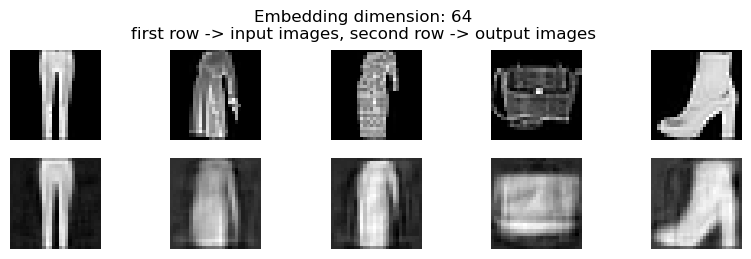

In [11]:
ex = 5

inputs = inputs[:ex]
outputs = outputs[:ex]

inputs = inputs.detach().numpy()
outputs_64 = outputs.detach().numpy()

plt.figure(figsize=(10, 4))

for i in range(ex):
    plt.subplot(3, ex, i + 1)
    plt.imshow(np.reshape(inputs[i], (28, 28)), cmap='gray')
    plt.axis('off')    

    plt.subplot(3, ex, i + ex + 1)
    plt.imshow(np.reshape(outputs_64[i], (28, 28)), cmap='gray')
    plt.axis('off')

plt.suptitle("Embedding dimension: 64\nfirst row -> input images, second row -> output images")

plt.show()

Seems better. Notice that we have not done perform any hyperparameter tuning and the number of epochs is relatively small. Finally, lets check the denoising autoencoder.

### Denoising autoencoder implementation

In [12]:
def add_noise(x, noise_factor = 0.5):
    noise = noise_factor * torch.randn_like(x)
    noisy_x = x + noise
    return torch.clamp(noisy_x, 0.0, 1.0)  # Clamps all elements in input into the range

noise_factor = 0.5

In [13]:
model = Autoencoder(784, 64) # 784 = 28 * 28
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3 )

epoch = 10
for e in range(epoch):
    train_loss = 0
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)
        noisy_inputs = add_noise(inputs, noise_factor)
        
        optimizer.zero_grad()
        outputs = model(noisy_inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    if (e + 1) % 2 == 0 or e == 0:
        print(f"Epoch: {e+1}\tTrain loss: {train_loss:.4f}")

Epoch: 1	Train loss: 30.4629
Epoch: 2	Train loss: 21.7326
Epoch: 4	Train loss: 19.5347
Epoch: 6	Train loss: 18.6614
Epoch: 8	Train loss: 18.1253
Epoch: 10	Train loss: 17.7462


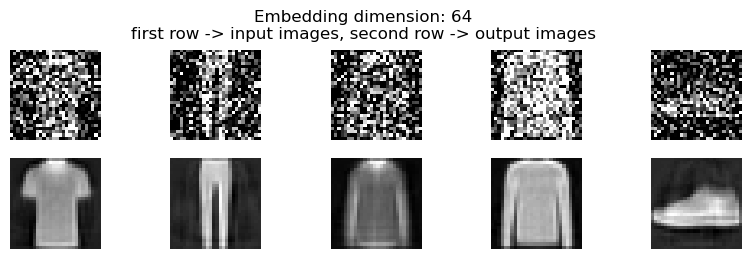

In [14]:
ex = 5

inputs = noisy_inputs[:ex]
outputs = outputs[:ex]

inputs = inputs.detach().numpy()
outputs_64 = outputs.detach().numpy()

plt.figure(figsize=(10, 4))

for i in range(ex):
    plt.subplot(3, ex, i + 1)
    plt.imshow(np.reshape(inputs[i], (28, 28)), cmap='gray')
    plt.axis('off')    

    plt.subplot(3, ex, i + ex + 1)
    plt.imshow(np.reshape(outputs_64[i], (28, 28)), cmap='gray')
    plt.axis('off')

plt.suptitle("Embedding dimension: 64\nfirst row -> input images, second row -> output images")

plt.show()

#### Now we are talking!